# COMPAS 

## Abstract
COMPAS er en algoritme utvikla for å anslå hvor trolig det er at en sikta person vil begå nye straffbare handlinger, og brukes utbredt i amerikansk rettvesen. Da nettavisen ProPublica i 2016 tok for seg ulike deler av algoritmen, synes det gjennomgående at algoritmen på bakgrunn av etnisitet ga hvite et lavere risikoanslag enn svarte. Vi skal i denne analysen ta for oss ulike deler av algoritmen gjennom å reprodusere resultatene til ProPublica. I den tilhørende etiske rapporten diskuterer vi behovet og det etiske grunnlaget for en slik algoritme.

## Datasettet

ProPublica hentet data om innsatte i Broward County, Florida, USA, og gjorde sin analyse av COMPAS basert på denne dataen. ProPublica har gjort dette datasettet fritt tilgjengelig, og det er det vi bruker i vår analyse.

Vi omformer kolonnene i datasettet noe, og ender opp med følgende kolonner som relevante for vår analyse:
 - Kolonnen `sex` angir kjønnet til personen 
 - Kolonnen `white` angir om personen er "hvit" eller ikke, hvor vi definerer hvit som gruppen "Caucasian" i det originale datasettet
 - Kolonnen `score` gir scoren som COMPAS ga personen
 - Kolonnen `predicted` indikerer om COMPAS predikerte personen til å begå nye lovbrudd
 - Kolonnen `actual` indikerer om personen faktisk begikk nye lovbrudd
 
I de tilfellene der oppgaven ber oss om å kun se på hvite og svarte, har vi valgt å dele etnisitet inn i "hvite" og "ikke-hvite". Delvis fordi det originale datasettet ikke bruker disse betegnelsene selv, slik at det gir rom for tolkning, og delvis fordi vi mener at en inndeling i "hvite" og "ikke-hvite" ikke utelukker de antatte tendensene som vi ønsker å utforske i denne oppgaven. 

In [23]:
import pandas as pd
import matplotlib.ticker as mtick
from IPython.core.display import display, HTML

def display_df_pct(df):
    display(HTML(df.to_html(float_format=lambda x: f'{x*100:.1f}%')))

data = pd.read_csv("../data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]
df = pd.DataFrame({ 
    "sex": data.sex,
    "white": data.race == "Caucasian",
    "score": data.decile_score,
    "predicted": data.score_text != "Low",
    "actual": data.is_recid == 1
})
df

,sex,white,score,predicted,actual
0,Male,False,1,False,False
1,Male,False,3,False,True
2,Male,False,4,False,True
5,Male,False,1,False,False
6,Male,True,6,True,True
...,...,...,...,...,...
7209,Male,False,7,True,False
7210,Male,False,3,False,False
7211,Male,False,1,False,False
7212,Female,False,2,False,False


## Predikerte og faktisk gjentatte forbrytelser

Vi lager firefeltstabeller for å se på hvor ofte ulike grupper (kvinner/menn og hvite/ikke-hvite) blir predikert å gjenta forbrytelser mot hvor ofte de faktisk gjør det.

In [24]:
def get_relative_frequency(group, target):
    group_size = len(df[group])
    target_size = len(df[group & target])
    rel_freq = target_size/group_size
    return f'{rel_freq*100:.1f}%'

def four_field_table(group, group_name, rest_name):
    return pd.DataFrame({
        "Predikert": [get_relative_frequency(group, df.predicted), get_relative_frequency(~group, df.predicted)],
        "Faktisk": [get_relative_frequency(group, df.actual), get_relative_frequency(~group, df.actual)],
    }, index = [group_name, rest_name])

### Predikerte og faktisk gjentatte forbrytelser etter etnisitet

In [4]:
four_field_table(df.white, "Hvite", "Ikke-hvite")

,Predikert,Faktisk
Hvite,33.1%,41.6%
Ikke-hvite,50.5%,52.0%


### Predikerte og faktisk gjentatte forbrytelser etter kjønn

In [5]:
four_field_table(df.sex == 'Male', "Menn", "Kvinner")

,Predikert,Faktisk
Menn,45.5%,51.1%
Kvinner,40.5%,37.0%


Fra tallene ser vi at det blant hvite er 8 prosentpoeng færre som blir predikert å begå nye lovbrudd enn som faktisk gjør det.
Det tilsvarende tallet for ikke-hvite er kun 2 prosentpoeng.
For menn er det seks prosentpoeng, og for kvinner -4 prosentpoeng.

Dette tyder på en "overprediksjon" for kvinner og betraktelig større "underprediksjon" for hvite enn ikke-hvite.

## Risiko for gjentatte forbrytelser

COMPAS gir hver gjerningsperson en vurdering fra 1 til 10, der høy verdi indikerer at det er trolig at personen vil begå nye lovbrudd. Vi ser på fordelingen av denne scoren i forskjellige grupper:

In [25]:
def plot_score_dist(df, title, group, group_name, rest_name, all_name = 'Alle'):
    ax = pd.DataFrame({
        all_name: df.score.value_counts(normalize = True),
        group_name: df[group].score.value_counts(normalize = True),
        rest_name: df[~group].score.value_counts(normalize = True)
    }).sort_index().plot.bar(title = title, style = {all_name: "k--"})
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


### Fordeling av score etter etnisitet

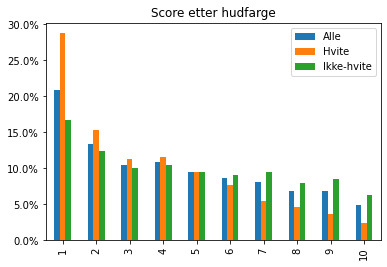

In [7]:
plot_score_dist(df, "Score etter hudfarge", df.white, "Hvite", "Ikke-hvite")

Her ser vi at de hvite (oransje) stolpene har en tilnærmet eksponesiell hellning mot venstre, slik at de lave risiko-scorene er overrepresentert. 
I venstre del av grafen er de ikke-hvite stolpene konsekvent lavere enn snittet, i høyre del er det motsatt. Dette betyr at en større andel av de ikke-hvite får høye risiko-scorer, enn blant de hvite.

### Fordeling av score etter kjønn

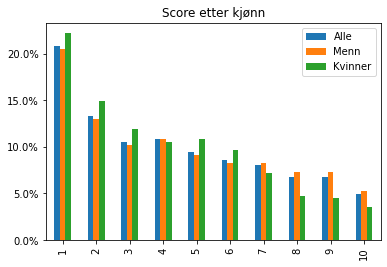

In [8]:
plot_score_dist(df, "Score etter kjønn", df.sex == 'Male', "Menn", "Kvinner")

For menn og kvinner ser vi ingen tydelig forskjell i grafene.

### Fordeling av score etter gjentatt forbrytelse

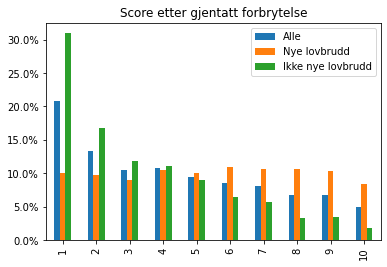

In [9]:
plot_score_dist(df, "Score etter gjentatt forbrytelse", df.actual, "Nye lovbrudd", "Ikke nye lovbrudd")

Vi ser, som ønsket, en avtagende trend for personer som ikke gjorde nye lovbrudd, men blant personer som gjorde nye lovbrudd er trenden flat.

### Fordeling av score etter gjentatte forbrytelser, hvite

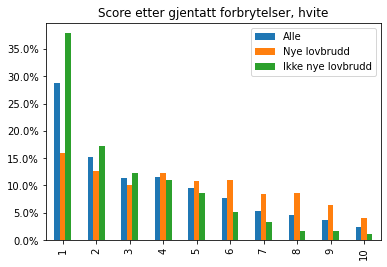

In [10]:
df_white = df[df.white]
plot_score_dist(df_white, "Score etter gjentatt forbrytelser, hvite", df_white.actual, "Nye lovbrudd", "Ikke nye lovbrudd")

### Fordeling av score etter gjentatte forbrytelser, ikke-hvite

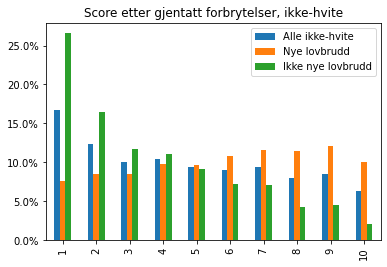

In [11]:
df_non_white = df[~df.white]
plot_score_dist(df_non_white, "Score etter gjentatt forbrytelser, ikke-hvite", df_non_white.actual, "Nye lovbrudd", "Ikke nye lovbrudd", "Alle ikke-hvite")

Vi ser, som ønsket, at en stor andel av de som ikke begikk nye lovbrudd fikk lav risiko-score. Men der score-grafen dipper nedover for høyere scorer for hvite som gjorde nye lovbrudd, går den oppover blant de ikke-hvite.

## Betinget sannsynlighet
Positiv prediktiv verdi er sannsynligheten for at en person som ble predikert å begå nye lovbrudd faktisk begikk nye lovbrudd. Sensitivitet er det "motsatte": sannsynligheten for at en person som faktisk begikk nye lovbrudd ble predikert å gjøre det.

For rettsvernet og enkeltmennesket kan en tenkes bør den positive prediktive verdien bør veie tyngre enn sensitiviteten. (Vi kan ikke ha en algoritme som dømmer uskyldige mennesker.)
Samtidig må samfunnssikkerheten også ivaretas: ved å øke sensitiviteten beskytter vi innbyggerne mot kriminalitet. 

Utifra Bayes setning ser vi at de to sannsynlighetene virker sammen: 
$$
A = \textrm {Tilbakefall} \\
B = \textrm {Predikert tilbakefall} \\ 
P(A | B) = \textrm {Positiv prediktiv verdi} \\
P(B | A) = \textrm {Sensitivitet} \\
P(A | B) = \frac{P(B | A) \cdot P(A)} {P(B)} 
$$
Den beste måten å øke sensitiviteten på er å utvikle en mer presis algoritme. Dersom dette ikke er mulig, kan sensitiviten økes hvis flere tilfeller predikeres å begå nye lovbrudd. I teorien kan sensitiviteten også økes ved å minske antall som faktisk begår nye lovbrudd, men dette er utenfor COMPAS sin rekkevidde. 

Hvis algoritmen øker andelen som predikeres til å begå nye lovbrudd, kan vi på samme måte lese ut ifra Bayes at den positive prediktive verdien vil minke. Dermed ser vi at man må finne en balansegang mellom positiv prediktiv verdi og sensitivitet. 



In [12]:
def conditional_prob(df):
    a = pd.DataFrame({
        "Ikke gjentatt": df[~df.actual].predicted.value_counts().sort_index(),
        "Gjentatt lovbrudd": df[df.actual].predicted.value_counts().sort_index()
    }).rename({False: "Ikke predikert", True: "Predikert"}) / len(df)
    display_df_pct(a)
    pos_pred = a["Gjentatt lovbrudd"]["Predikert"] / a.loc["Predikert"].sum()
    print(f"Pos. pred. verdi: {pos_pred*100:.1f}%")
    sens = a["Gjentatt lovbrudd"]["Predikert"] / a["Gjentatt lovbrudd"].sum()
    print(f"    Sensitivitet: {sens*100:.1f}%")

### Alle

In [13]:
conditional_prob(df)

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,36.4%,19.0%
Predikert,15.1%,29.4%


Pos. pred. verdi: 66.0%
    Sensitivitet: 60.8%


### Hvite

In [14]:
conditional_prob(df[df.white])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,45.8%,21.1%
Predikert,12.6%,20.4%


Pos. pred. verdi: 61.8%
    Sensitivitet: 49.2%


### Ikke-hvite

In [15]:
conditional_prob(df[~df.white])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,31.6%,17.9%
Predikert,16.4%,34.1%


Pos. pred. verdi: 67.5%
    Sensitivitet: 65.5%


### Menn

In [16]:
conditional_prob(df[df.sex == 'Male'])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,34.6%,19.9%
Predikert,14.3%,31.2%


Pos. pred. verdi: 68.6%
    Sensitivitet: 61.1%


### Kvinner

In [17]:
conditional_prob(df[df.sex == 'Female'])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,44.3%,15.2%
Predikert,18.7%,21.8%


Pos. pred. verdi: 53.8%
    Sensitivitet: 58.9%


I firefeltstabellen er de sanne negative finnes øverst til venstre, falske negative øverst til høyre, falske positive nederst til venstre og de sanne positive nederst til høyre. 
Fordelingen av disse når man sammenlikner hvite og ikke-hvite kan indikere at algoritmen er diskriminerende overfor ikke-hvite. Vi ser at andelen falske positive er større for ikke-hvite enn hvite, samtidig som andelen falske negative er større blant hvite. Denne forskjellen reflekteres i sensitiviteten, som er markant lavere hos hvite enn ikke-hvite. Dette tyder på at algoritmen er mer aggressiv når det kommer til å predikere tilbakefall hos ikke-hvite enn hvite. Den lave sensitiviteten hos hvite indikerer indikerer at deres rettssikkerhet i større grad blir ivaretatt enn hos ikke-hvite. 

Det er også verdt å merke at kvinner har betraktelig lavere positiv prediktiv verdi (53,8%) enn alle (66%). Algoritmen tar oftere feil for kvinner enn for menn. 

Til tross for at disse funnene støtter opp om at COMPAS er diskriminerende, kan ikke konkludere før vi har isolert faktorene. 

# Predikere prediksjonen

Vi trener en logistisk modell for å se hvilken vekt som blir tilegnet predikatoren som indikerer "African-American".

In [18]:
from sklearn.linear_model import LogisticRegression
import numpy as np

categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

Y = data["score_text"] != "Low"

model = LogisticRegression(max_iter=1000)
model.fit(X, Y)

print(model.coef_)
print(model.intercept_)

[[ 0.26841574  0.68318404 -1.34534445  1.30150177  0.47767854 -0.20805671
  -0.42133031  0.8956289  -0.80592196  0.2188144  -0.30988952]]
[-1.52332792]


Med alle vektene og bias, kalkulerer vi bias mot "African-American" som gruppe, ved å sammenlikne en idealisert person som kun har egenskapen å være "African-American" mot en person som ikke har noen egenskaper.

In [19]:
black_coef = model.coef_[0, list(X.columns).index('race_African-American')]
intercept = model.intercept_[0]

control = 1/(1+np.exp(-intercept))
racialBias = np.exp(black_coef) / (1 + control * (np.exp(black_coef) - 1))
racialBias

1.4530844530784157

Tallet forteller oss at det å være "African-American" gir en 45% større sjanse for å bli predikert å begå nye lovbrudd, enn en 

In [20]:
print(X.columns)

Index(['priors_count', 'two_year_recid', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'race_African-American', 'race_Asian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female',
       'c_charge_degree_M'],
      dtype='object')


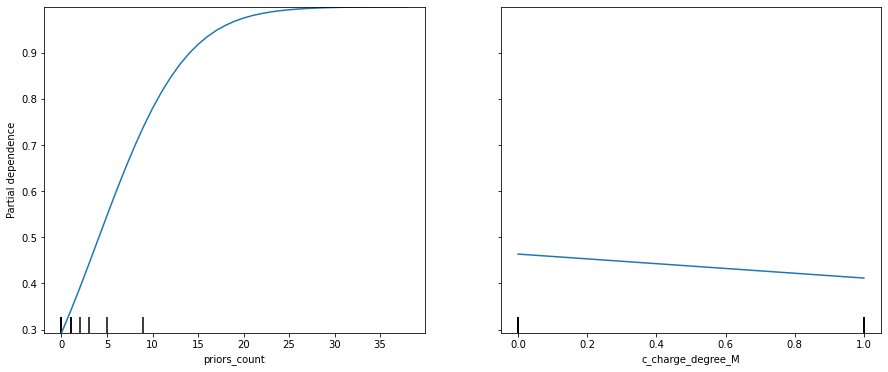

In [21]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
features = ["priors_count", "c_charge_degree_M"]
plot_partial_dependence(model, X, features)
plt.gcf().set_size_inches(15, 6)
plt.show()

Observerer hvordan scorens avhengighet av priors_count øker eksponsielt.  
Forholdet mellom target og c_charge_degree_M er negativt. 

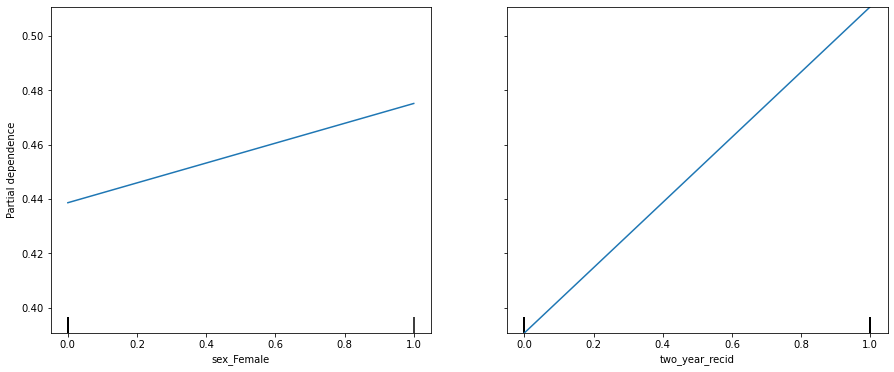

In [22]:
features = ["sex_Female", "two_year_recid"]
plot_partial_dependence(model, X, features)
plt.gcf().set_size_inches(15, 6)

Både sex_Female og two_year_recid har positiv partial dependence. Partial dependence støtter opp om våre tidligere antakelser om at grafen er biased for kvinner. 